# Sentiment Analysis of Technology Tweets from South by Southwest

#### Authors: Amelia Dahm and Eric Roberts

## Project Overview <a id="Overview"></a>

[1. Business Problem](#Business-Problem)

[2. Data Understanding and Preparation](#Data-Understanding)

[3. EDA](#EDA)

[4. Modeling](#Modeling)

[5. Evaluation](#Evaluation)

[6. Conclusion](#Conclusion)


***

## Business Problem <a id="Business-Problem"></a>
##### [(back to top)](#Overview)

Social media, in particular Twitter, has become the defacto forum in which consumers voice praise or criticism for products and events.  It is becoming increasingly important for companies to identify both positive and negative tweets in real-time in order to respond to criticism and highlight praise.  However, given the volume of tweets this is a neigh impossible task to accomplish manually. Therefore this project aimed to build a prediction model to classify the sentiment of tweets as positive, negative, or neutral to allow companies to identify and respond to them in real-time. Not only is it critical to label the sentiment of tweets, but we also want to understand the content of these tweets to identify patterns, if any, in the responses.  Therefore in addition to building a prediction model, we perform a content analysis on our set of tweets to demonstrate the utility for understanding patterns in our data.

As a test case we build our model using tweets regarding major technology brands from the South by Southwest (SXSW) festival; large festivals are huge opportunities for companies to showcase their products and generate sales.  After showcasing a new product it is critical companies know how it is being received.  Similarly, technology festivals themselves are huge businesses and maintaining their relevance requires understanding what worked well, as well as responding to participant criticism.  This makes this data set an ideal test case with many potential stake holders.

***

## Data Understanding and Preperation <a id="Data-Understanding"></a>
##### [(back to top)](#Overview)

This data source is entitled 'Brands and Product Emotions' from [CrowdFlower](https://data.world/crowdflower/brands-and-product-emotions). The dataset has 9093 records that include tweets with an assigned brand/product and emotion. 




In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import TomekLinks
from sklearn.utils import resample
import string, re
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.metrics import plot_confusion_matrix

In [2]:
#import cleaned, final dataset
df = pd.read_csv('data/dataframe.csv', index_col=0)
df.head()

,tweet,product_,emotion,lemmatizer_tweets,textblob_polarity,textblob_subjectivity,vs_neg,vs_neu,vs_pos,vs_compound,nrc_sentiment,gi_sentiment,henry_sentiment,huliu_sentiment,jockers_sentiment,lm_sentiment,senticnet_sentiment,sentiword_sentiment,socal_sentiment,product_agg
0,"['wesley83', 'have', '3G', 'iPhone', '3', 'hrs...",iPhone,0,wesley83 have 3G iPhone 3 hr tweeting RISE Aus...,-0.200000,0.400000,0.223,0.777,0.000,-0.6486,0.0,-0.333333,0.0,-1.0,-1.000000,0.0,-0.09520,-0.221875,-1.192154,Apple
1,"['jessedee', 'Know', 'fludapp', 'Awesome', 'iP...",iPad or iPhone App,1,jessedee Know fludapp Awesome iPad iPhone app ...,0.466667,0.933333,0.000,0.528,0.472,0.9100,1.0,1.000000,0.0,1.0,0.416667,0.0,0.47500,0.175000,2.177190,Apple
2,"['swonderlin', 'not', 'wait', 'iPad', '2', 'al...",iPad,1,swonderlin not wait iPad 2 also should sale do...,-0.155556,0.288889,0.000,1.000,0.000,0.0000,-1.0,-1.000000,-1.0,-1.0,-0.625000,-1.0,-0.30550,-0.289062,-1.000000,Apple
3,"['sxsw', 'hope', 'year', 'festival', 't', 'cra...",iPad or iPhone App,0,sxsw hope year festival t crashy this year iPh...,0.000000,0.000000,0.000,0.596,0.404,0.7269,1.0,1.000000,0.0,0.0,0.500000,0.0,0.07160,0.250000,2.841547,Apple
4,"['sxtxstate', 'great', 'stuff', 'Fri', 'SXSW',...",Google,1,sxtxstate great stuff Fri SXSW Marissa Mayer G...,0.800000,0.750000,0.000,0.796,0.204,0.6249,0.0,1.000000,0.0,1.0,0.500000,1.0,0.55125,0.083333,1.554026,Google


In [3]:
df.emotion.value_counts()

3    5388
1    2978
0     570
4     156
Name: emotion, dtype: int64

In [4]:
df.dtypes

tweet                     object
product_                  object
emotion                    int64
lemmatizer_tweets         object
textblob_polarity        float64
textblob_subjectivity    float64
vs_neg                   float64
vs_neu                   float64
vs_pos                   float64
vs_compound              float64
nrc_sentiment            float64
gi_sentiment             float64
henry_sentiment          float64
huliu_sentiment          float64
jockers_sentiment        float64
lm_sentiment             float64
senticnet_sentiment      float64
sentiword_sentiment      float64
socal_sentiment          float64
product_agg               object
dtype: object

***

## EDA <a id="EDA"></a>
##### [(back to top)](#Overview)

Exploratory data analysis included graphing the distribution of labels and brands in the dataset overall and by valence of the product.  Further we tabulated the word frequecy overall, by product and by valence.

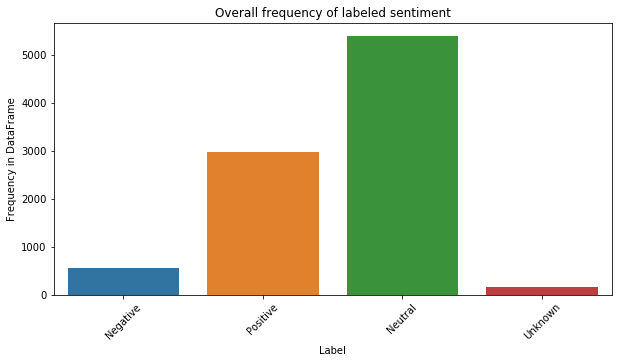

In [5]:
# The overall frequency of tweet sentiment in the dataframe
plt.figure(figsize=(10,5))
chart = sns.countplot(x='emotion', data=df)
chart.set_xticklabels(labels=['Negative','Positive','Neutral','Unknown'], rotation=45);
chart.set_xlabel('Label');
chart.set_ylabel('Frequency in DataFrame');
chart.set_title('Overall frequency of labeled sentiment');

* Large imbalance in labels
* Neutral is the majority category, followed by positive, negative and a few unknown sentiment.

<Figure size 720x360 with 0 Axes>

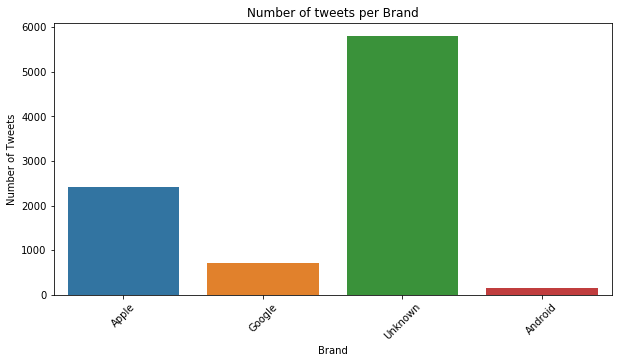

In [6]:
# The overall frequency of aggregated brand mentions in the dataframe
plt.figure(figsize=(10,5))
plt.figure(figsize=(10,5))
chart = sns.countplot(x='product_agg', data=df, )
chart.set_xticklabels(labels=['Apple','Google','Unknown','Android'], rotation=45);
chart.set_xlabel('Brand');
chart.set_ylabel('Number of Tweets');
chart.set_title('Number of tweets per Brand');

#### Interpretation:
* Unknown category is big majority - more than 2x Apple. 
* Apple has more than 3x the number of tweets than Google.  
* Android is tiny fraction.

Mean vs_neg by product
product_agg
Android    0.025572
Apple      0.042899
Google     0.031533
Unknown    0.030386
Name: vs_neg, dtype: float64
F_onewayResult(statistic=15.167096905650649, pvalue=7.644024880781393e-10)
Median vs_neg by product
product_agg
Android    0.0
Apple      0.0
Google     0.0
Unknown    0.0
Name: vs_neg, dtype: float64
KruskalResult(statistic=52.39334429331721, pvalue=2.4692885033332857e-11)


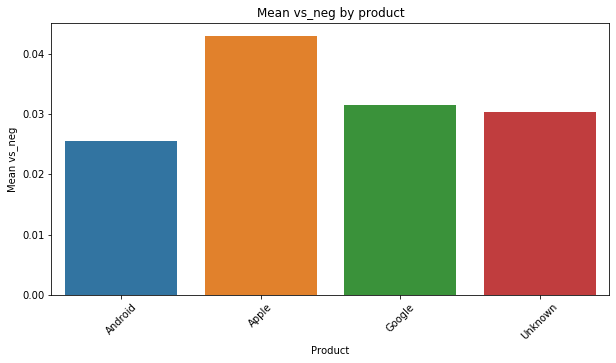

In [7]:
#Analyzing the distribution of tweets for brands by sentiment

#importing custom function that takes as arguments the dataframe to use
#and the sentiment variable to assess 
#returns groupby means and medians, ANOVA and kruskall-wallis

import py_files.bivariable_analyzer as bivariable_analyzer

bivariable_analyzer.bivar_analyzer(df, 'vs_neg')

* Apple has the highest mean negative score - investigate by product breakdown
* Google and unknown are roughly equal
* Android, following on the polarity above, have the lowest % negative.

Mean vs_pos by product
product_agg
Android    0.218717
Apple      0.160098
Google     0.176119
Unknown    0.101251
Name: vs_pos, dtype: float64
F_onewayResult(statistic=155.76177500552683, pvalue=1.9039433405980362e-98)
Median vs_pos by product
product_agg
Android    0.203
Apple      0.156
Google     0.167
Unknown    0.000
Name: vs_pos, dtype: float64
KruskalResult(statistic=440.44618466655436, pvalue=3.829970213407436e-95)


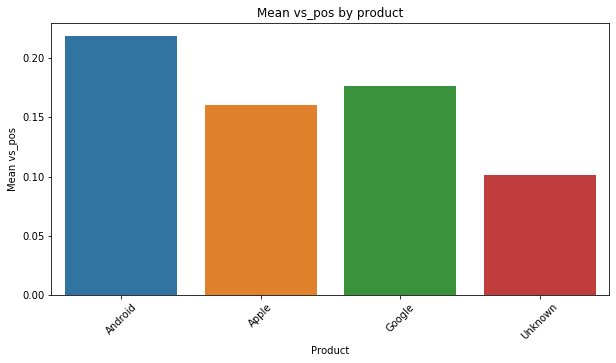

In [8]:
bivariable_analyzer.bivar_analyzer(df, 'vs_pos')

* Android the most positive
* Apple lowest of the main products. 
* Unknown lowest positive

Mean VS neg by apple product
product_
Apple                             0.038233
Other Apple product or service    0.043343
iPad                              0.042960
iPad or iPhone App                0.029857
iPhone                            0.073673
Name: vs_neg, dtype: float64
F_onewayResult(statistic=14.939143039082458, pvalue=1.326413349889096e-09)
Median VS neg by apple product
product_
Apple                             0.0
Other Apple product or service    0.0
iPad                              0.0
iPad or iPhone App                0.0
iPhone                            0.0
Name: vs_neg, dtype: float64
KruskalResult(statistic=41.589478040156365, pvalue=4.903213939772419e-09)


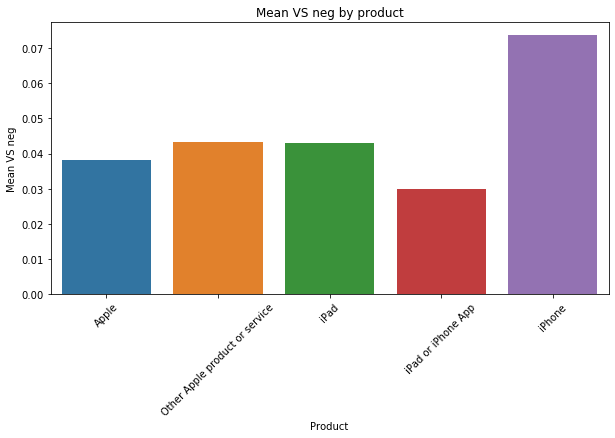

In [9]:
#Apple was the brand with the highest average negative score.  Here assessing whether there
#was a difference by specific Apple Product.

#subsetting to only apple tweets
df_apple = df.loc[df['product_agg'] == 'Apple',:]\

#subsetting by product
iPad = df_apple.loc[df_apple['product_'] == 'iPad', 'vs_neg']
apple_app = df_apple.loc[df_apple['product_'] == 'iPad or iPhone App', 'vs_neg']
iPhone = df_apple.loc[df_apple['product_'] == 'iPhone', 'vs_neg']
Other_apple = df_apple.loc[df_apple['product_'] == 'Other Apple product or service', 'vs_neg']

#Calculating groupby means and medians, ANOVA and kruskal-wallis
a = df_apple.groupby(['product_'])['vs_neg'].mean()
print('Mean VS neg by apple product')
print(a)
print(sp.f_oneway(iPad, apple_app, iPhone, Other_apple))
print('Median VS neg by apple product')
print(df_apple.groupby(['product_'])['vs_neg'].median())
print(sp.kruskal(iPad, apple_app, iPhone, Other_apple))

#plotting mean VS negative score by product
plt.figure(figsize=(10,5))
chart = sns.barplot(x=a.index,y=a, data=df_apple, )
chart.set_xticklabels(labels=a.index, rotation=45);
chart.set_xlabel('Product');
chart.set_ylabel('Mean VS neg');
chart.set_title('Mean VS neg by product');

* Of the apple products the most negative is the iphone.  Note the scale of the y-axis.  This is relatively true but not necessarily absolutely true.

Overall vocab of subset: 23
30 most common words in subset:
[('sxsw', 3), ('iphone', 2), ('quot', 2), ('danger', 1), ('sitting', 1), ('floor', 1), ('charging', 1), ('laptop', 1), ('ipod', 1), ('etc', 1), ('dreaded', 1), ('dead', 1), ('butt', 1), ('damn', 1), ('tingle', 1), ('sxnewworlds', 1), ('suffering', 1), ('ipad', 1), ('envy', 1), ('exposing', 1), ('horrendous', 1), ('battery', 1), ('life', 1)]
Word 		 Normalized Frequency

sxsw 		 0.1111
iphone 		 0.07407
quot 		 0.07407
danger 		 0.03704
sitting 		 0.03704
floor 		 0.03704
charging 		 0.03704
laptop 		 0.03704
ipod 		 0.03704
etc 		 0.03704
dreaded 		 0.03704
dead 		 0.03704
butt 		 0.03704
damn 		 0.03704
tingle 		 0.03704
sxnewworlds 		 0.03704
suffering 		 0.03704
ipad 		 0.03704
envy 		 0.03704
exposing 		 0.03704
horrendous 		 0.03704
battery 		 0.03704
life 		 0.03704


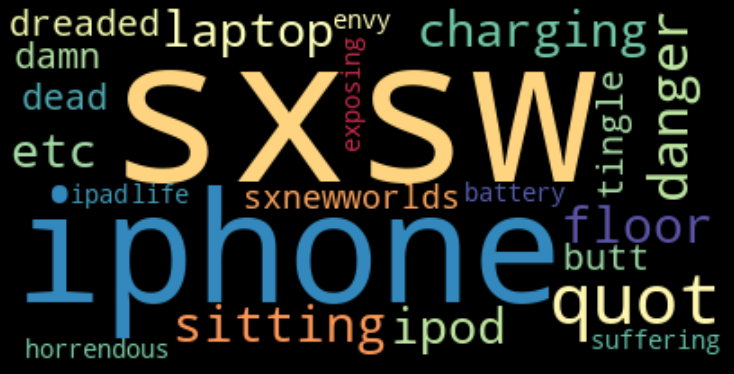

In [10]:
#Creating word clouds 

#importing custom function that takes as an argument the original tweets as a series subset
#by whatever feature you would like to assess word frequency of.
#returns overall vocab of the subset, 30 most common words, normalized freq and word cloud.

import py_files.word_count as word_count

data_neg = df.loc[df['vs_neg'] >= 0.5,'tweet']
word_count.word_count_func(data_neg)

Overall vocab of subset: 468
30 most common words in subset:
[('sxsw', 144), ('mention', 95), ('party', 41), ('link', 38), ('win', 37), ('ipad', 37), ('rt', 37), ('google', 34), ('thanks', 33), ('free', 27), ('best', 24), ('great', 23), ('iphone', 21), ('app', 19), ('android', 16), ('yes', 16), ('awesome', 14), ('good', 13), ('award', 13), ('fun', 12), ('music', 12), ('need', 12), ('love', 11), ('gowalla', 11), ('andoid', 11), ('team', 11), ('choice', 11), ('apple', 10), ('well', 9), ('com', 9)]
Word 		 Normalized Frequency

sxsw 		 0.09424
mention 		 0.06217
party 		 0.02683
link 		 0.02487
win 		 0.02421
ipad 		 0.02421
rt 		 0.02421
google 		 0.02225
thanks 		 0.0216
free 		 0.01767
best 		 0.01571
great 		 0.01505
iphone 		 0.01374
app 		 0.01243
android 		 0.01047
yes 		 0.01047
awesome 		 0.009162
good 		 0.008508
award 		 0.008508
fun 		 0.007853
music 		 0.007853
need 		 0.007853
love 		 0.007199
gowalla 		 0.007199
andoid 		 0.007199
team 		 0.007199
choice 		 0.007199
apple 	

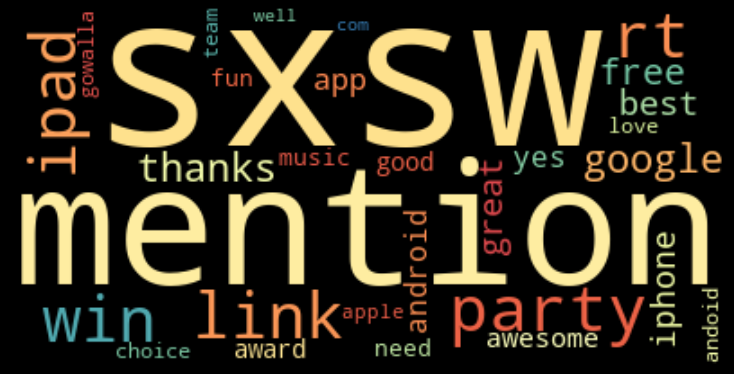

In [11]:
data_pos = df.loc[df['vs_pos'] >= 0.5,'tweet']
word_count.word_count_func(data_pos)

In both sets of tweets 'SXSW' and 'mention' appear frequently suggesting most people, irrespective of sentiment, were tagging their experience at the festival and directing their tweet.  Words appearing more often in the positive tweets were 'Link' and 'rt' (re-tweet) suggesting people are linking to or retweeting new products they like. Other clusters of words including 'line' 'today'/'tomorrow' 'launch' and the brand or product names (in particular iPad 2) suggest general excitment for the festival or products being launched.  Finally, there appeared to be general 'thanks'/'congrats' for 'seeing'/'meeting' someone potentially at a 'party'.

Words that were more frequent among the negative tweets were 'hotspots'/'internet', 'check-in', 'tool'/'mobile', 'restaurants', and 'experimenting'/'tinkering'. These hint at complaints related to the following areas: infrastructure, mobile app, and experience.  We would guess, people want fast internet, a streamlined experience and more time to interact with products.

***

## Modeling <a id="Modeling"></a>
##### [(back to top)](#Overview)


The goal of this project was to classify tweets into sentiment categories: positive, negative, neutral, and unclear.  For classying the tweets into these categories, we tested random forest models and neural networks. Before fitting the data to the models, we lemmatized the tweets, removed stop words, and used a tfidf vectorizer. This process was iterative. 

In [12]:
## setting stopwords and punctuations
stop_words=stopwords.words("english")
stop_words += list(string.punctuation)
stop_words += ['...','u','w','2',"i'm",'via',"we're",'6','3','hey']
# print(stop_words)
sw_set = set(stop_words)

In [13]:
neg = df[df.emotion==0]
pos = df[df.emotion==1]
idk = df[df.emotion==4]
neu = df[df.emotion==3]

In [14]:
# upsample negative
neg_upsampled = resample(neg,
                          replace=True, # sample with replacement
                          n_samples=len(neu), # match number in majority class
                          random_state=23) # reproducible results

# upsample positive
pos_upsampled = resample(pos,
                          replace=True, # sample with replacement
                          n_samples=len(neu), # match number in majority class
                          random_state=23) # reproducible results

# upsample unclear
idk_upsampled = resample(idk,
                          replace=True, # sample with replacement
                          n_samples=len(neu), # match number in majority class
                          random_state=23) # reproducible results

upsampled = pd.concat([neu, neg_upsampled, pos_upsampled, idk_upsampled])

In [15]:
# creating a list with all lemmatized outputs
data = upsampled['lemmatizer_tweets']
lemmatized_output = []

for listy in data:
    lemmed = ''.join([w for w in listy])
    lemmatized_output.append(lemmed)

In [16]:
# define x and y
X_lem = lemmatized_output
y_lem = upsampled['emotion']

In [17]:
# train test split the lemmatized words
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)

# fit and transform
tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

In [18]:
# Average number of non-zero elements in vectorized tweets
non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print(non_zero_cols)

# Percentage of columns containing zero
percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print(percent_sparse)

22.46952032944725
0.9994795107637376


#### Random Forest

In [19]:
# Create, fit, and predict on data

# Instatiate classifier
rf_lem = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# fit model to lemmatized tfidf data
rf_lem.fit(tfidf_data_train_lem, y_train_lem)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [20]:
rf_train_preds_lem = rf_lem.predict(tfidf_data_train_lem)
metrics.accuracy_score(y_train_lem, rf_train_preds_lem)

0.9979119540629894

In [21]:
# predict on test set
rf_test_preds_lem = rf_lem.predict(tfidf_data_test_lem)

# get metrics
rf_acc_score_lem = metrics.accuracy_score(y_test_lem, rf_test_preds_lem)
rf_f1_score_lem = metrics.f1_score(y_test_lem, rf_test_preds_lem, average='weighted')
rf_precision_score_lem = metrics.precision_score(y_test_lem, rf_test_preds_lem, average='weighted')
rf_recall_score_lem = metrics.recall_score(y_test_lem, rf_test_preds_lem, average='weighted')
print('Accuracy:', rf_acc_score_lem)
print('Precision:',rf_precision_score_lem)
print('Recall:',rf_recall_score_lem)
print('F1:',rf_f1_score_lem)

Accuracy: 0.9220598469032707
Precision: 0.9210386351303297
Recall: 0.9220598469032707
F1: 0.9212052860626472


#### Grid Search

In [22]:
# # Instatiate classifier
# rfc=RandomForestClassifier(random_state=42)

# # what parameters to test
# param_grid = { 
#     'n_estimators': list(range(130,140)),
#     'max_features': ['auto'],
#     'max_depth' : list(range(18,20)),
#     'criterion' : ['gini']}

# # search and fit model
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(tfidf_data_train_lem, y_train_lem)

# # # print metrics
# print('Best Score:', CV_rfc.best_score_)
# print('Best Parameters:',CV_rfc.best_params_)
# print('Best Estimator:',CV_rfc.best_estimator_)

In [23]:
# pulled the parameters from the grid search .best_params_
rfc=RandomForestClassifier(max_depth=19, n_estimators=130, random_state=42, criterion='gini', max_features='auto')

In [24]:
# fit the model
rfc.fit(tfidf_data_train_lem, y_train_lem)

RandomForestClassifier(max_depth=19, n_estimators=130, random_state=42)

In [25]:
# predict on test set
rf_test_preds_lem1 = rfc.predict(tfidf_data_test_lem)

In [26]:
# get metrics
rf_acc_score_lem1 = metrics.accuracy_score(y_test_lem, rf_test_preds_lem1)
rf_f1_score_lem1 = metrics.f1_score(y_test_lem, rf_test_preds_lem1, average='weighted')
rf_precision_score_lem1 = metrics.precision_score(y_test_lem, rf_test_preds_lem1, average='weighted')
rf_recall_score_lem1 = metrics.recall_score(y_test_lem, rf_test_preds_lem1, average='weighted')
print('Accuracy:', rf_acc_score_lem1)
print('Precision:',rf_precision_score_lem1)
print('Recall:',rf_recall_score_lem1)
print('F1:',rf_f1_score_lem1)

Accuracy: 0.7531895151936906
Precision: 0.7518645665718574
Recall: 0.7531895151936906
F1: 0.749382720827409


#### Neural Network

In [27]:
# update outcome category
df['emotion'] = np.where(df['emotion'] == 4, 2, df['emotion'])

In [28]:
# grab numerical features
data = df.drop(columns=['emotion', 'tweet', 'product_', 'lemmatizer_tweets'])
target = df['emotion']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=1)
# Look at shape for inputs
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7273, 16)
(1819, 16)
(7273,)
(1819,)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=1)

# tomek links for class imbalance
tl = TomekLinks()
X_train, y_train = tl.fit_resample(X_train, y_train)

# how many folds to separate data
batch_size = 8
# how many classes in outcomes
num_classes = 4
epochs = 15

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = y_train.astype('uint8')
y_test = y_test.astype('uint8')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# specifying the model structure
model = Sequential()

# specify the first hidden layer
model.add(Dense(100, activation='relu', input_shape=(15,)))
model.add(Dropout(0.2))

# specify the second layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))

# specify the third layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))

# specify the output layer
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

ValueError: could not convert string to float: 'Unknown'

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

***

## Evaluation <a id="Evaluation"></a>
##### [(back to top)](#Overview)

This process was iterative. To evaluate our models, we used accuracy scores. The final iteration of our best model was the random forest model using grid search that gave us a 0.6728 accuracy.  

#### Model Metrics

In [31]:
print('Model Metrics:')
print(' - Accuracy:', rf_acc_score_lem)
print(' - Precision:',rf_precision_score_lem)
print(' - Recall:',rf_recall_score_lem)
print(' - F1:',rf_f1_score_lem)

Model Metrics:
 - Accuracy: 0.9220598469032707
 - Precision: 0.9210386351303297
 - Recall: 0.9220598469032707
 - F1: 0.9212052860626472


#### Confusion Matrix

Confusion matrix, without normalization
[[1097    0    0    0]
 [   4  911  130    0]
 [  27  160  872   15]
 [   0    0    0 1095]]
Normalized confusion matrix
[[1.         0.         0.         0.        ]
 [0.00382775 0.87177033 0.12440191 0.        ]
 [0.02513966 0.14897579 0.81191806 0.01396648]
 [0.         0.         0.         1.        ]]


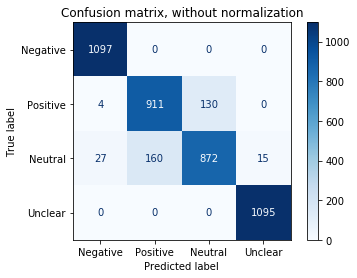

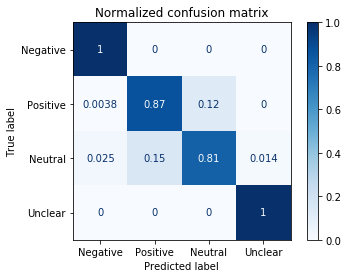

In [32]:
class_names = ['Negative', 'Positive', 'Neutral', 'Unclear']

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf_lem, tfidf_data_test_lem, y_test_lem,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('./images/rfc_confusion_matrix.png')    
plt.show()

***

## Conclusion <a id="Conclusion"></a>
##### [(back to top)](#Overview)

Overall, we report a model with high accuracy in predicting the sentiment of technology related tweets.  Additionally, we delivered actionable insights from our content analysis for heads of technology brands and festival organizers.

The dataset is restricted to tweets from one festival in one year limiting its generalizability. To illustrate, this data set is from the 2011 SXSW when the iPad 2 was released, hence it's high frequency count among tweets with a positive valence.  However, it's likely that as technology updates older versions of products may be referenced negatively.  Incorporating tweets from consequtive years may help address this shortcoming.

Furthermore, our prediction model was fit to the entire dataset.  It's possible improvements in prediction, and utility, may come from training the model to identify positive and negative tweets related to specific brands.